# Reproduction of Fig. S7

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from functools import partial
from tqdm.notebook import tqdm
from pyscripts.config import path2
from pyscripts.datasets import Metadata, DatasetLoader
from pyscripts.visualization import ColorUniversalDesign as CUD
dloader = DatasetLoader()
metadata = Metadata()

In [2]:
gtdbrep2refseq = metadata.acc.set_index('gtdbrep')['refseq']
refseq2gtdbrep = metadata.acc.set_index('refseq')['gtdbrep']
acc_ordered = pd.DataFrame([
    (refseq_acc, gtdb_acc)
    for gtdb_acc in metadata.bac120_tree.iter_leaf_names() 
    if (refseq_acc := gtdbrep2refseq.get(gtdb_acc)) is not None
], columns=['refseq', 'gtdbrep'])
gtdb_taxonomy = metadata.taxrank_inuse.loc[acc_ordered['gtdbrep']]

phylum_counts = gtdb_taxonomy['phylum'].value_counts()[gtdb_taxonomy['phylum'].unique()]
top_idx = phylum_counts[phylum_counts >= 40].sort_values(ascending=False).index
phylum_masked = gtdb_taxonomy['phylum'].where(gtdb_taxonomy['phylum'].isin(top_idx), '(others)')
phylum_color = (phylum_counts.rank(method='first', ascending=False).astype(int)-1).apply(CUD.OkabeIto_cmap)

In [3]:
idp_summary = pd.read_pickle(
    path2.data/'iupred2a'/'summary.pkl.bz2'
).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1)
idp_fw2rc1 = idp_summary[30,0.5].loc[[4,8]].sum() / idp_summary[30,0].loc[[4,8]].sum()

In [4]:
from multiprocessing import Pool

def get_ncds_longestrep(gcf):
    rec = max(dloader.load_genome(gcf), key=len)
    return gcf, sum(1 for f in rec.features if f.type == 'CDS')

with Pool(60) as pool:
     ncds_longestrep = pd.Series(dict(tqdm(pool.imap_unordered(get_ncds_longestrep, acc_ordered['refseq']))))

0it [00:00, ?it/s]

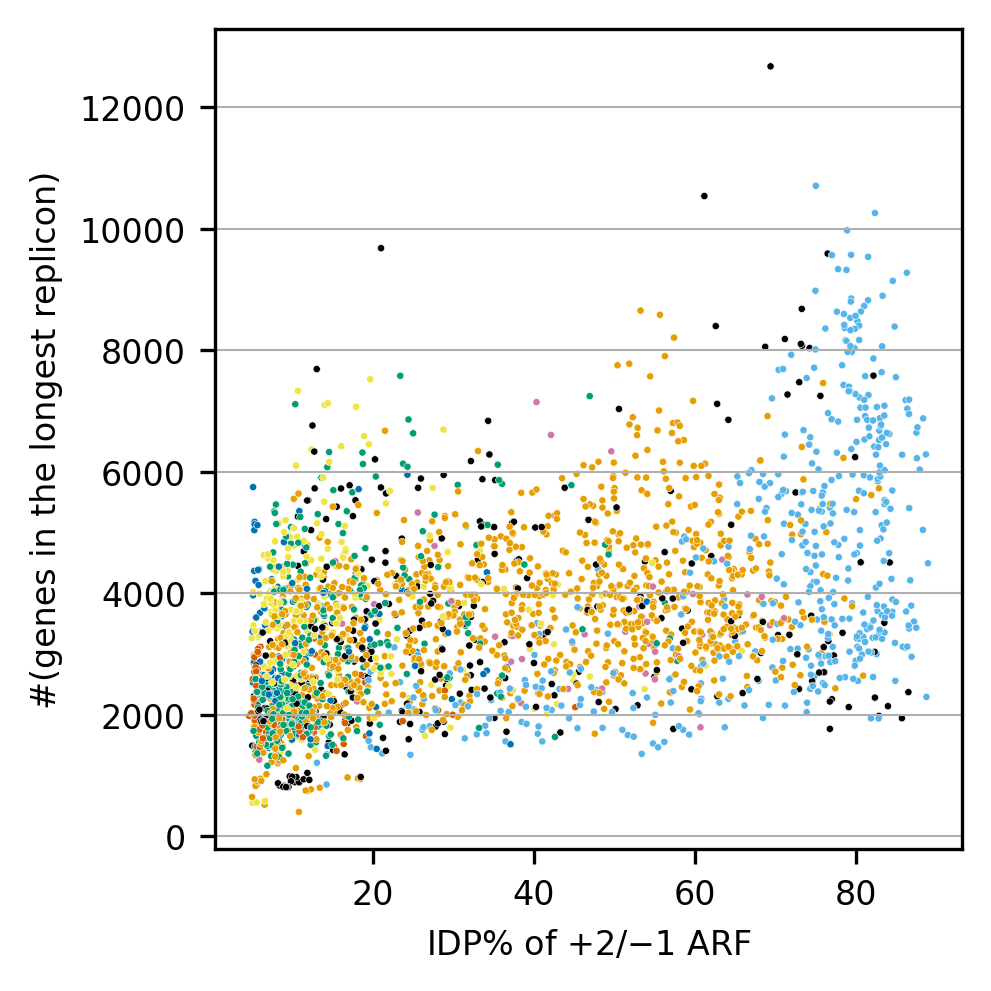

In [7]:
mm = 1 / 25.4
with plt.rc_context({'font.size': 8}):
    fig, ax = plt.subplots(figsize=(85*mm, 85*mm), dpi=300)
    pltdat = pd.concat(
        [idp_fw2rc1*100, ncds_longestrep, refseq2gtdbrep.map(phylum_masked)], axis=1, 
        keys=['idp', 'gsize', 'phylum']
    )
    sns.scatterplot(
        x='idp', y='gsize', hue='phylum', hue_order=[*top_idx, '(others)'], data=pltdat,
        palette=CUD.OkabeIto_cpal, s=3, ax=ax
    )
    ax.legend().remove()
    #ax.legend(fontsize=6, ncol=2, bbox_to_anchor=(0.5, -0.2), loc='upper center')
    ax.set_xlabel('IDP% of $+2$/$-1$ ARF')
    ax.set_ylabel('#(genes in the longest replicon)')
    ax.yaxis.grid(lw=0.5)
    fig.tight_layout()
    #fig.savefig('./Figs/FigS7.jpeg', dpi=200)
    fig.savefig('./Figs/FigS7.pdf')
    fig.patch.set_facecolor('w')
    fig.savefig('./Figs/FigS7.tif')
    